In [1]:
import numpy as np
from astropy import coordinates as coo
from astropy import units as u
import healpy as hp
import matplotlib.pyplot as plt
import multiprocessing as mp
from astropy.io import fits

In [2]:
Nside_jack = 3
def weight_nan_mean(value, weight):
    mean_val = np.zeros(value.shape[1])
    for i in range(len(mean_val)):
        idx = np.logical_not(np.isnan(value[:,i]))
        val = value[idx,i]
        wei = weight[idx,i]
        mean_val[i] = np.average(val, weights=wei)
    return mean_val

In [3]:
dat = np.load('../calculation_data/result_r=3_100_15_quasar_cut.npy')
dat_r = np.load('../calculation_data/result_r=3_100_15_quasar_random_cut.npy')
value = dat[0]
weight = dat[1]
value_r = dat_r[0]
weight_r = dat_r[1]

quasar_cata = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/DR16Q_v4.fits')
quasar_cata = quasar_cata[quasar_cata['Z'] > 1]
quasar_cata = quasar_cata[quasar_cata['Z'] < 3]

c = coo.SkyCoord(ra=quasar_cata['RA']*u.degree, dec=quasar_cata['DEC']*u.degree)

l = c.galactic.l.to(u.rad).value
b = c.galactic.b.to(u.rad).value
pix = hp.ang2pix(Nside_jack, theta=np.pi/2-b, phi=l)

print('finish loading quasar catalogue')

rand_theta, rand_phi, rand_z = np.load('../catalogue/random_sample_quasar.npy')
l = rand_phi
b = np.pi/2 - rand_theta
pix_r = hp.ang2pix(Nside_jack, theta=rand_theta, phi=rand_phi)

print('finish loading random sample')

finish loading quasar catalogue
finish loading random sample


## quasar sample

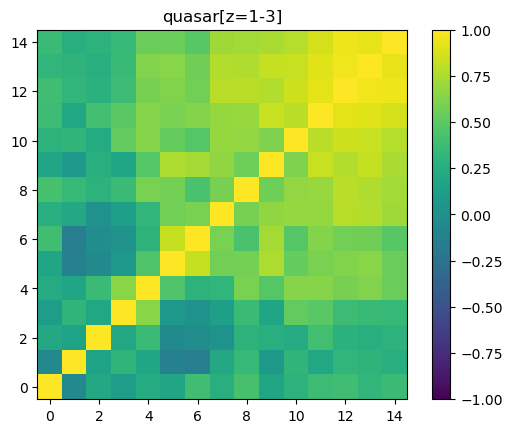

In [4]:
mean = weight_nan_mean(value, weight)
def jackknife_resample_q(i):
    idx = pix != i
    return weight_nan_mean(value[idx], weight[idx])
pro = mp.Pool(20)
result = pro.map(jackknife_resample_q, np.unique(pix))
jack_val_q = np.vstack(result)
cov_mat = np.cov(jack_val_q, ddof=1, rowvar=False)
std = np.std(jack_val_q, axis=0, ddof=1)
for i in range(cov_mat.shape[0]):
    for j in range(cov_mat.shape[0]):
        cov_mat[i,j] /= std[i]*std[j]
std*=len(result)**0.5
plt.imshow(cov_mat, origin='lower', vmin=-1, vmax=1)
plt.colorbar()
plt.title('quasar[z=1-3]')
plt.show()

## random sample

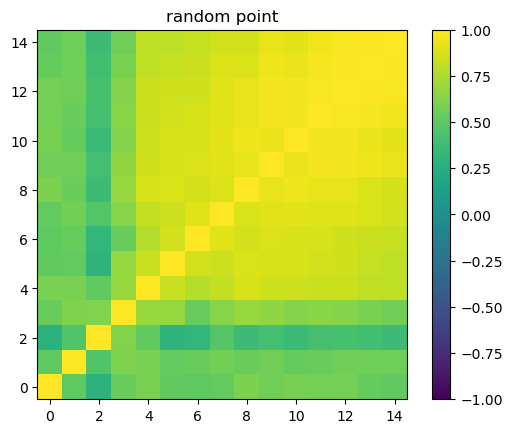

In [5]:
mean_r = weight_nan_mean(value_r, weight_r)
def jackknife_resample_r(i):
    idx = pix_r != i
    return weight_nan_mean(value_r[idx], weight_r[idx])
pro = mp.Pool(20)
result = pro.map(jackknife_resample_r, np.unique(pix_r))
jack_val_r = np.vstack(result)
cov_mat = np.cov(jack_val_r, ddof=1, rowvar=False)
std_r = np.std(jack_val_r, axis=0, ddof=1)
for i in range(cov_mat.shape[0]):
    for j in range(cov_mat.shape[0]):
        cov_mat[i,j] /= std_r[i]*std_r[j]
std_r*=len(result)**0.5
plt.imshow(cov_mat, origin='lower', vmin=-1, vmax=1)
plt.title('random point')
plt.colorbar()
plt.show()

## quasar - random

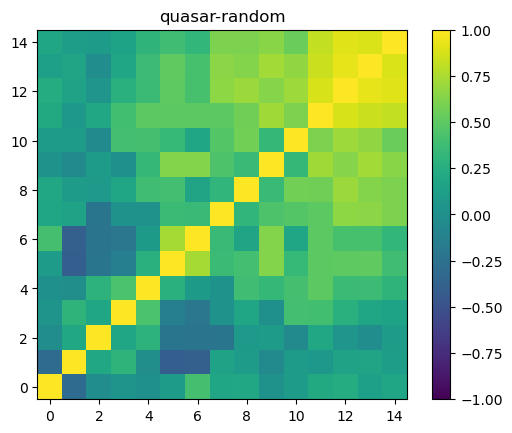

In [6]:
def jackknife_resample(i):
    idx = pix != i
    idx_r = pix_r != i
    return weight_nan_mean(value[idx], weight[idx])-weight_nan_mean(value_r[idx_r], weight_r[idx_r])
pro = mp.Pool(20)
result = pro.map(jackknife_resample, np.unique(pix))
jack_val = np.vstack(result)
cov_mat = np.cov(jack_val, ddof=1, rowvar=False)
std_sub = np.std(jack_val, axis=0, ddof=1)
for i in range(cov_mat.shape[0]):
    for j in range(cov_mat.shape[0]):
        cov_mat[i,j] /= std_sub[i]*std_sub[j]
std_sub*=len(result)**0.5
plt.imshow(cov_mat, origin='lower', vmin=-1, vmax=1)
plt.title('quasar-random')
plt.colorbar()
plt.show()

## signal

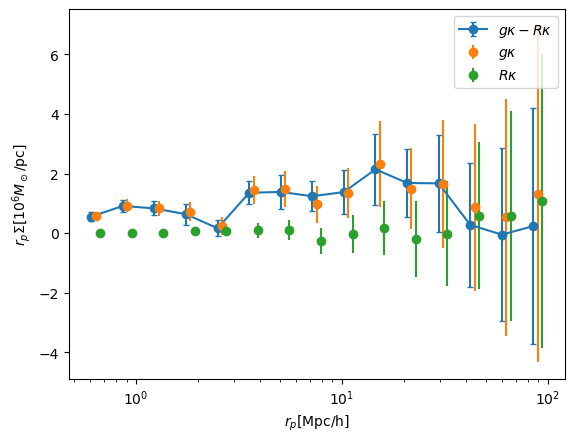

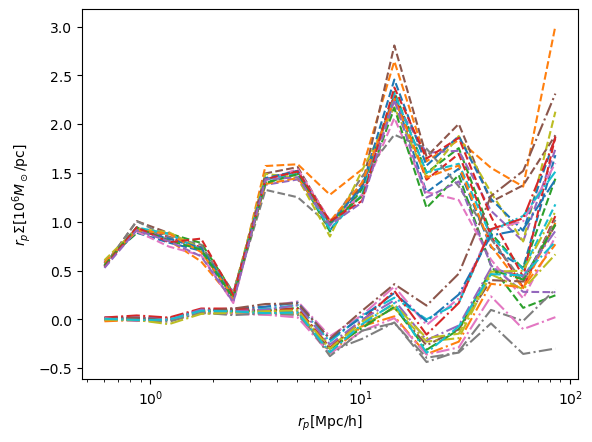

In [8]:
r_bins = np.geomspace(0.5, 100, 15+1)        # unit: cMpc/h
r = (r_bins[1:]+r_bins[:-1])/2
sig = mean-mean_r
plt.errorbar(r, r*sig, r*std_sub, capsize=2, fmt='-o', label='$g\\kappa-R\\kappa$')
plt.errorbar(r*1.05, r*mean, r*std, label='$g\\kappa$', fmt='o')
plt.errorbar(r*1.05*1.05, r*mean_r, r*std_r, label='$R\\kappa$', fmt='o')
plt.semilogx()
plt.xlabel('$r_p[\\mathrm{Mpc/h}]$')
plt.ylabel('$r_p\\Sigma[10^6 M_\\odot/\\mathrm{pc}]$')
# plt.ylim(top=50)
plt.legend()
plt.savefig('./fig/quasar_random_l_cut.jpg')
plt.show()

for i in range(jack_val_q.shape[1]):
    plt.plot(r, r*jack_val_q[i], '--')
for i in range(jack_val_r.shape[1]):
    plt.plot(r, r*jack_val_r[i], '-.')

plt.semilogx()
plt.xlabel('$r_p[\\mathrm{Mpc/h}]$')
plt.ylabel('$r_p\\Sigma[10^6 M_\\odot/\\mathrm{pc}]$')

plt.savefig('./fig/quasar_random_jack_l_cut.jpg')
plt.show()

In [18]:
dat_r = np.load('../calculation_data/result_r=3_100_15_random_sample_quasar_narrow_z_cut_tree.npy')
value_r = dat_r[0]
weight_r = dat_r[1]

quasar_cata = np.load('../catalogue/random_sample_quasar_narrow_z_cut.npy')

c = coo.SkyCoord(ra=quasar_cata['ra']*u.degree, dec=quasar_cata['dec']*u.degree)
l = c.galactic.l.to(u.rad).value
b = c.galactic.b.to(u.rad).value
pix_r = hp.ang2pix(Nside_jack, theta=np.pi/2-b, phi=l)

mean_r = weight_nan_mean(value_r, weight_r)
def jackknife_resample_r(i):
    idx = pix_r != i
    return weight_nan_mean(value_r[idx], weight_r[idx])
pro = mp.Pool(20)
result = pro.map(jackknife_resample_r, np.unique(pix_r))
jack_val_r = np.vstack(result)
std_r = np.std(jack_val_r, axis=0, ddof=1)*np.sqrt(len(result))

In [20]:
dat_h = np.load('../calculation_data/result_r=3_100_15_quasar_narrow_z_cut_high_tree.npy')
value_h = dat_h[0]
weight_h = dat_h[1]

quasar_cata = np.load('../catalogue/quasar_narrow_z_cut_high.npy')

c = coo.SkyCoord(ra=quasar_cata['ra']*u.degree, dec=quasar_cata['dec']*u.degree)
l = c.galactic.l.to(u.rad).value
b = c.galactic.b.to(u.rad).value
pix_h = hp.ang2pix(Nside_jack, theta=np.pi/2-b, phi=l)

mean_h = weight_nan_mean(value_h, weight_h)
def jackknife_resample_q(i):
    idx = pix_h != i
    return weight_nan_mean(value_h[idx], weight_h[idx])
pro = mp.Pool(20)
result = pro.map(jackknife_resample_q, np.unique(pix_h))
jack_val_h = np.vstack(result)
std_h = np.std(jack_val_h, axis=0, ddof=1)*np.sqrt(len(result))

In [21]:
dat_l = np.load('../calculation_data/result_r=3_100_15_quasar_narrow_z_cut_low_tree.npy')
value_l = dat_l[0]
weight_l = dat_l[1]

quasar_cata = np.load('../catalogue/quasar_narrow_z_cut_low.npy')

c = coo.SkyCoord(ra=quasar_cata['ra']*u.degree, dec=quasar_cata['dec']*u.degree)
l = c.galactic.l.to(u.rad).value
b = c.galactic.b.to(u.rad).value
pix_l = hp.ang2pix(Nside_jack, theta=np.pi/2-b, phi=l)
mean_l = weight_nan_mean(value_l, weight_l)
def jackknife_resample_q(i):
    idx = pix_l != i
    return weight_nan_mean(value_l[idx], weight_l[idx])
pro = mp.Pool(20)
result = pro.map(jackknife_resample_q, np.unique(pix_l))
jack_val_l = np.vstack(result)
std_l = np.std(jack_val_l, axis=0, ddof=1)*np.sqrt(len(result))

In [22]:
def jackknife_resample(i):
    idx = pix_h != i
    idx_r = pix_r != i
    return weight_nan_mean(value_h[idx], weight_h[idx])-weight_nan_mean(value_r[idx_r], weight_r[idx_r])
pro = mp.Pool(20)
result = pro.map(jackknife_resample, np.unique(pix_h))
jack_val = np.vstack(result)
std_sub_h = np.std(jack_val, axis=0, ddof=1)*np.sqrt(len(result))

In [23]:
def jackknife_resample(i):
    idx = pix_l != i
    idx_r = pix_r != i
    return weight_nan_mean(value_l[idx], weight_l[idx])-weight_nan_mean(value_r[idx_r], weight_r[idx_r])
pro = mp.Pool(20)
result = pro.map(jackknife_resample, np.unique(pix_l))
jack_val = np.vstack(result)
std_sub_l = np.std(jack_val, axis=0, ddof=1)*np.sqrt(len(result))

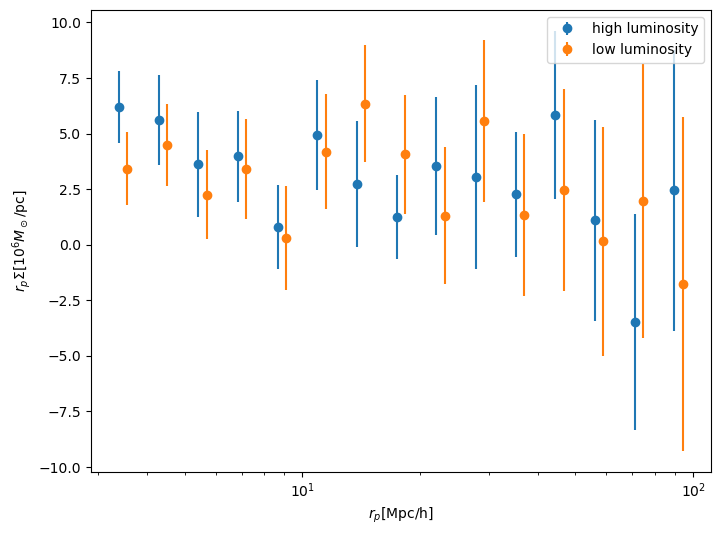

In [24]:
r_bins = np.geomspace(3, 100, 15+1)        # unit: cMpc/h
r = (r_bins[1:]+r_bins[:-1])/2
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(r, r*mean_h, r*std_h, label='high luminosity', fmt='o')
ax.errorbar(r*1.05, r*mean_l, r*std_l, label='low luminosity', fmt='o')
ax.semilogx()
ax.set_xlabel('$r_p[\\mathrm{Mpc/h}]$')
ax.set_ylabel('$r_p\\Sigma[10^6 M_\\odot/\\mathrm{pc}]$')
# plt.ylim(top=100, bottom=-100)
ax.legend()
plt.show()

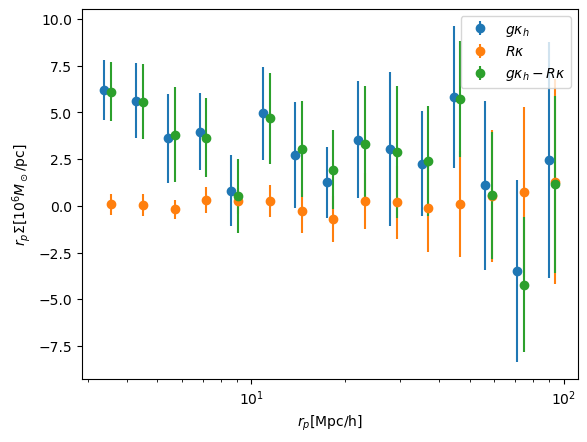

In [25]:
fig, ax = plt.subplots()
ax.errorbar(r, r*mean_h, r*std_h, label='$g\\kappa_h$', fmt='o')
ax.errorbar(r*1.05, r*mean_r, r*std_r, label='$R\\kappa$', fmt='o')
ax.errorbar(r*1.05, r*(mean_h-mean_r), r*std_sub_h, label='$g\\kappa_h-R\\kappa$', fmt='o')
# ax.errorbar(r*1.05, r*mean_l, r*std_l, label='low luminosity', fmt='o')
ax.semilogx()
ax.set_xlabel('$r_p[\\mathrm{Mpc/h}]$')
ax.set_ylabel('$r_p\\Sigma[10^6 M_\\odot/\\mathrm{pc}]$')
# plt.ylim(top=100, bottom=-100)
ax.legend()
plt.show()

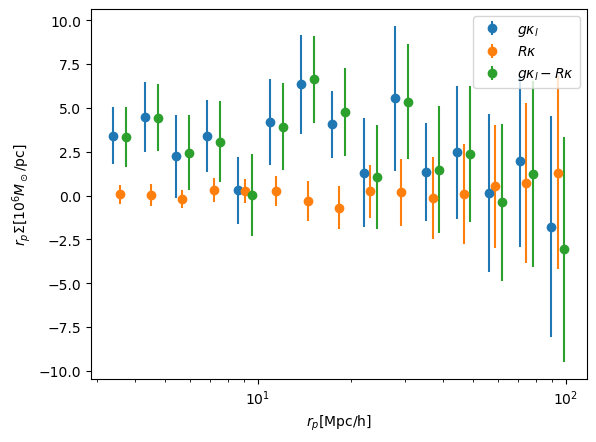

In [26]:
fig, ax = plt.subplots()
ax.errorbar(r, r*mean_l, r*std_h, label='$g\\kappa_l$', fmt='o')
ax.errorbar(r*1.05, r*mean_r, r*std_r, label='$R\\kappa$', fmt='o')
ax.errorbar(r*1.05*1.05, r*(mean_l-mean_r), r*std_sub_l, label='$g\\kappa_l-R\\kappa$', fmt='o')
ax.semilogx()
ax.set_xlabel('$r_p[\\mathrm{Mpc/h}]$')
ax.set_ylabel('$r_p\\Sigma[10^6 M_\\odot/\\mathrm{pc}]$')
# plt.ylim(top=100, bottom=-100)
ax.legend()
plt.show()

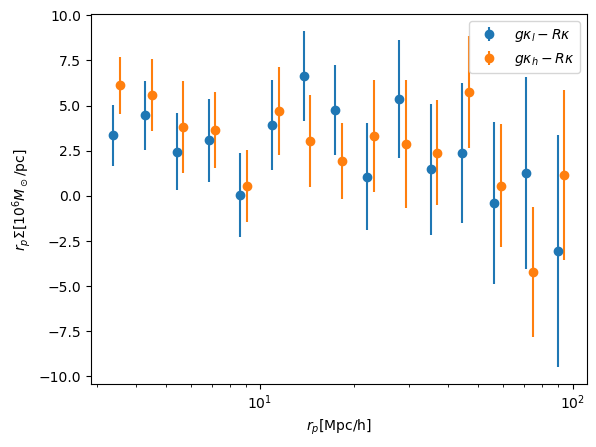

In [27]:
fig, ax = plt.subplots()
ax.errorbar(r, r*(mean_l-mean_r), r*std_sub_l, label='$g\\kappa_l-R\\kappa$', fmt='o')
ax.errorbar(r*1.05, r*(mean_h-mean_r), r*std_sub_h, label='$g\\kappa_h-R\\kappa$', fmt='o')
ax.semilogx()
ax.set_xlabel('$r_p[\\mathrm{Mpc/h}]$')
ax.set_ylabel('$r_p\\Sigma[10^6 M_\\odot/\\mathrm{pc}]$')
ax.legend()
plt.show()